In [44]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

plt.style.use('fivethirtyeight')

In [45]:
nfl_elo_df = pd.read_csv('nfl_elo.csv')
columns_to_drop = [
    'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj',
    'elo1_post', 'elo2_post', 'qb1_game_value', 'qb2_game_value',
    'qb1_value_post', 'qb2_value_post', 'qbelo1_post', 'qbelo2_post'
]
nfl_elo_df = nfl_elo_df.drop(columns=columns_to_drop)
nfl_elo_df['date'] = pd.to_datetime(nfl_elo_df['date'])
nfl_elo_df['winner'] = np.where(nfl_elo_df['score1'] > nfl_elo_df['score2'], nfl_elo_df['team1'], nfl_elo_df['team2'])
nfl_elo_df = nfl_elo_df[nfl_elo_df['date'].dt.year >= 1970]
nfl_elo_df = nfl_elo_df[(nfl_elo_df['date'].dt.month >= 9) | (nfl_elo_df['date'].dt.month <= 2)]
nfl_elo_df['favored_team'] = np.where(nfl_elo_df['elo_prob1'] > nfl_elo_df['elo_prob2'], nfl_elo_df['team1'], nfl_elo_df['team2'])
nfl_elo_df['favored_team_won'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['winner'], 'Won', 'Lost')
nfl_elo_df['favored_qb'] = np.where(nfl_elo_df['qbelo_prob1'] > nfl_elo_df['qbelo_prob2'], nfl_elo_df['team1'], nfl_elo_df['team2'])
nfl_elo_df['favored_qb_won'] = np.where(nfl_elo_df['favored_team'] == nfl_elo_df['winner'], 'Won', 'Lost')
nfl_elo_df['team_elo_difference'] = abs(nfl_elo_df['elo1_pre'] - nfl_elo_df['elo2_pre'])
nfl_elo_df['qb_elo_difference'] = abs(nfl_elo_df['qbelo1_pre'] - nfl_elo_df['qbelo2_pre'])
nfl_elo_df['team_elo_difference_bins'] = pd.qcut(nfl_elo_df['team_elo_difference'], q=3, labels=['Low', 'Medium', 'High'])
nfl_elo_df['qb_elo_difference_bins'] = pd.qcut(nfl_elo_df['qb_elo_difference'], q=3, labels=['Low', 'Medium', 'High'])

Now we test the correlation between a higher elo prior to the start of the game and then the outcome of the game. The null hypothesis is a lack of correlation while the alternative hypothesis is that there is a relationship between the winners elo and the favored team winning. This will help us understand if the winning teams elo 

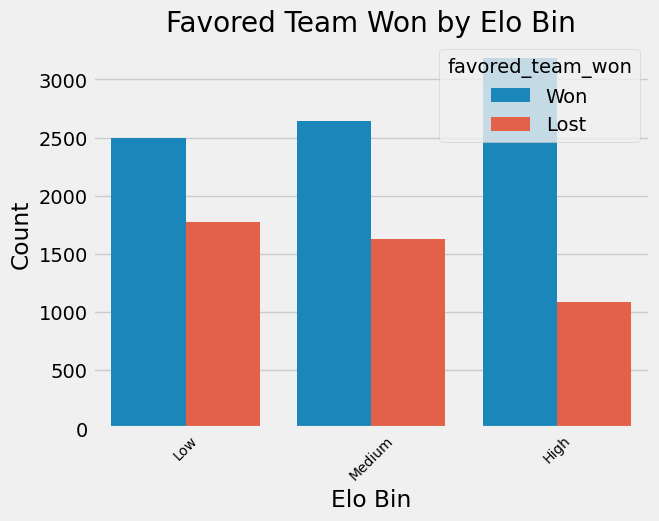

In [46]:
sns.countplot(x='team_elo_difference_bins', hue='favored_team_won', data=nfl_elo_df)

plt.title('Favored Team Won by Elo Bin')
plt.xlabel('Elo Bin')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [47]:
contingency_table_season = pd.crosstab(nfl_elo_df['team_elo_difference_bins'], nfl_elo_df['favored_team_won'])
contingency_table_season
chi2 = stats.chi2_contingency(contingency_table_season)
print(f"P-Value: {chi2.pvalue}")


P-Value: 7.7010432802584655e-59


And now we extend the same ideas to the qb elos to determine if there's a correlation between a team winning based on their qb's elo. Null hypothesis relates to no relation while an alternative hypothesis states there is a correlation.

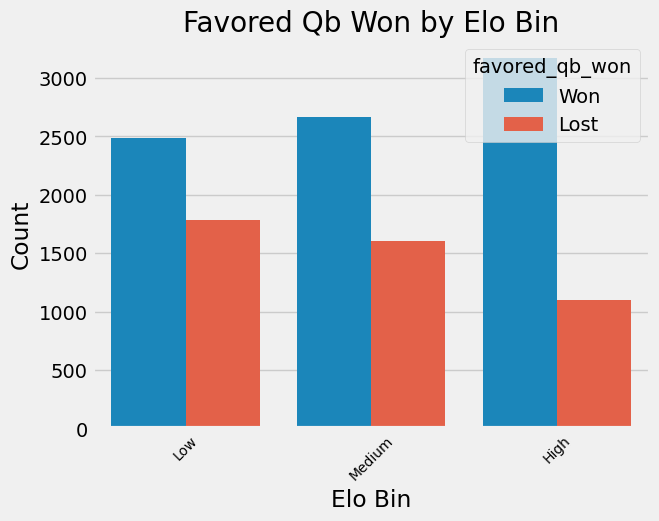

In [48]:
sns.countplot(x='qb_elo_difference_bins', hue='favored_qb_won', data=nfl_elo_df)

plt.title('Favored Qb Won by Elo Bin')
plt.xlabel('Elo Bin')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [49]:
contingency_table_playoff = pd.crosstab(nfl_elo_df['qb_elo_difference_bins'], nfl_elo_df['favored_qb_won'])
contingency_table_playoff
chi2 = stats.chi2_contingency(contingency_table_playoff)
print(f"P-Value: {chi2.pvalue}")

P-Value: 8.729081314786217e-57


Now, we take a look at past performances by Kansas City and determine what metrics seperates a super bowl caliber team versus a regular team. We define super bowl caliber team as a team that at least played in the conference finals. 
We first import the data and clean it 

In [56]:
team_data = pd.read_csv('team_data.csv')

#take modern data of when the league was at least 28 teams
team_data = team_data[(team_data['out of'] == 32) & (team_data['Year'] < 2024)]
team_data['winning_pct'] = team_data['W'] / (team_data['W'] + team_data['L'])
team_data['Games'] = team_data['W'] + team_data['L'] + team_data['T']
team_data.fillna({'Playoffs': 'Did not make Playoffs'}, inplace=True)
#normalize data to per game data to allow for comparison between seasons of different lengths
for data in ['PF', 'PA', 'PD']:
    team_data[data] = team_data[data] / team_data['Games']

#seperate data of superbowl caliber teams and non superbowl caliber teams
sb_data = team_data[team_data['Playoffs'].str.contains('SB') | team_data['Playoffs'].str.contains('Conf')]
non_sb_data = team_data[~team_data['Playoffs'].str.contains('SB') & ~team_data['Playoffs'].str.contains('Conf')]
sb_data

,Year,Lg,Tm,W,L,T,Div. Finish,Playoffs,PF,PA,...,Pts±,Yds±,out of,MoV,SoS,SRS,OSRS,DSRS,winning_pct,Games
1,2023,NFL,Kansas City Chiefs*,11,6,0,1st of 4,Won SB,21.823529,17.294118,...,6,7,32,4.5,-0.8,3.7,-0.6,4.4,0.647059,17
2,2022,NFL,Kansas City Chiefs*,14,3,0,1st of 4,Won SB,29.176471,21.705882,...,4,2,32,7.5,-1.2,6.2,6.8,-0.6,0.823529,17
3,2021,NFL,Kansas City Chiefs*,12,5,0,1st of 4,Lost Conf,28.235294,21.411765,...,5,11,32,6.8,0.6,7.4,5.4,2.0,0.705882,17
4,2020,NFL,Kansas City Chiefs*,14,2,0,1st of 4,Lost SB,29.562500,22.625000,...,6,3,32,6.9,-0.1,6.8,4.5,2.3,0.875000,16
5,2019,NFL,Kansas City Chiefs*,12,4,0,1st of 4,Won SB,28.187500,19.250000,...,4,10,32,8.9,0.2,9.1,6.2,2.9,0.750000,16
6,2018,NFL,Kansas City Chiefs*,12,4,0,1st of 4,Lost Conf,35.312500,26.312500,...,2,11,32,9.0,-0.1,8.9,12.6,-3.8,0.750000,16


In [57]:
#use t-tests to find which stats indicate a statistical different between superbowl winning teams and non superbowl winning teams
stats_list = ['winning_pct', 'PF', 'PA', 'PD']
for stat in stats_list:
    print(stat, stats.ttest_ind(sb_data[stat], non_sb_data[stat]).pvalue)

#use Wilcoxon rank sum for rank data
rank_list = ['OffPts', 'OffYds', 'DefPts', 'DefYds']
for stat in rank_list:
    print(stat, stats.ranksums(sb_data[stat], non_sb_data[stat]).pvalue)

winning_pct 0.011542131111451083
PF 0.026462367288040155
PA 0.7524148665938686
PD 0.035810790552714314
OffPts 0.05527028067627238
OffYds 0.018320735421941195
DefPts 0.25317348676295626
DefYds 0.460994786425578


From this set of data we can see winning percentage, points for, points differential, offensive yards per game rank, and offensive points per game (almost 0.05 significant) is what is statistically different between a super bowl caliber Kansas City team versus a regular Kansas City team

Next, We plot some of the data to see visually how the super bowl caliber teams compare. The box and whiskers are plotted using non-sb team data. and the data points are plotted on top of the box and whisker to see where they fall in comparison to the mean. 

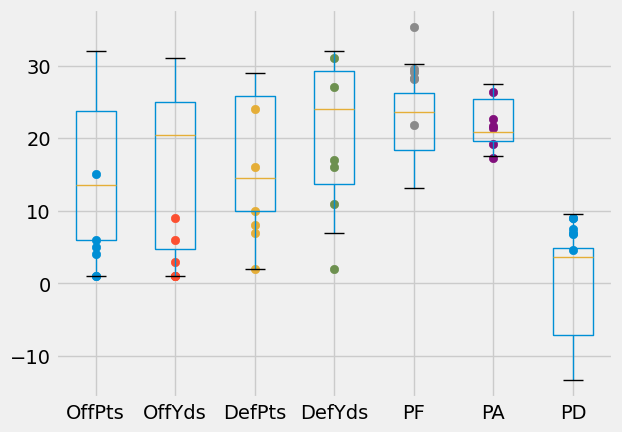

In [59]:
percentage_stats = ['OffPts', 'OffYds', 'DefPts', 'DefYds', 'PF', 'PA', 'PD']
non_sb_data.boxplot(column= percentage_stats)

for i, stat in enumerate(percentage_stats, start=1):
    y = sb_data[stat]
    x = [i] * len(y)
    plt.scatter(x, y)